In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor  
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression 
from matplotlib.colors import LinearSegmentedColormap
from sklearn.tree import DecisionTreeRegressor 
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
from tabulate import tabulate
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv(r'C:\Users\dell\Desktop\MyDocs\Docs\MK\GenZ_DatingApp_Data.csv')
df = data.copy()
df.head()

,User_ID,Age,Gender,Location,Education,Occupation,Primary_App,Secondary_Apps,Usage_Frequency,Daily_Usage_Time,Reason_for_Using,Satisfaction,Challenges,Desired_Features,Preferred_Communication,Partner_Priorities
0,1,20,Non-binary,Bangalore,Undergraduate,Freelancer,Hinge,Hinge,Monthly,1 hour,Finding a Partner,4,Safety Concerns,Audio Calls,Video Calls,Values > Personality > Appearance
1,2,24,Female,Delhi,Undergraduate,Part-time Job,Hinge,OkCupid,Weekly,30 minutes,Casual Dating,5,Time-Wasting,Video Calls,Text,Values > Personality > Appearance
2,3,24,Non-binary,Kolkata,Undergraduate,Intern,NaN,NaN,Weekly,2 hours,Casual Dating,4,Safety Concerns,Detailed Profiles,Text,Values > Personality > Appearance
3,4,22,Non-binary,Delhi,Graduate,Full-time Job,NaN,OkCupid,Daily,30 minutes,Casual Fun,3,NaN,AI Recommendations,Voice Notes,Personality > Interests > Values
4,5,18,Male,Delhi,Graduate,Intern,OkCupid,OkCupid,Weekly,2 hours,Casual Fun,4,Safety Concerns,Video Calls,Text,Appearance > Interests > Personality


In [3]:
colors = ["#2c3e50", "#34495e", "#7f8c8d", "#e74c3c", "#c0392b"]
ordered_colors = [colors[0], colors[3], colors[2], colors[1], colors[4]]
sns.set_palette(colors)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   User_ID                  500 non-null    int64 
 1   Age                      500 non-null    int64 
 2   Gender                   500 non-null    object
 3   Location                 500 non-null    object
 4   Education                500 non-null    object
 5   Occupation               500 non-null    object
 6   Primary_App              393 non-null    object
 7   Secondary_Apps           386 non-null    object
 8   Usage_Frequency          500 non-null    object
 9   Daily_Usage_Time         500 non-null    object
 10  Reason_for_Using         500 non-null    object
 11  Satisfaction             500 non-null    int64 
 12  Challenges               383 non-null    object
 13  Desired_Features         500 non-null    object
 14  Preferred_Communication  500 non-null    o

In [5]:
df.shape

(500, 16)

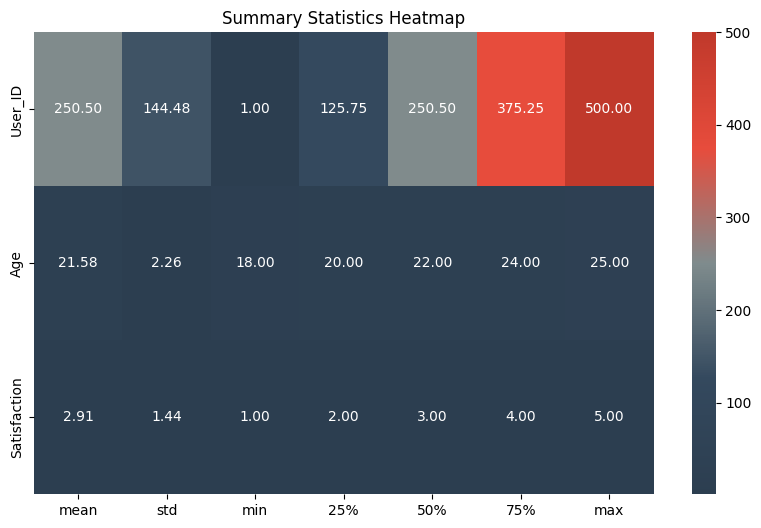

In [6]:
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
desc = df.describe().T

plt.figure(figsize=(10, 6))
sns.heatmap(desc[['mean', 'std', 'min', '25%', '50%', '75%', 'max']], annot=True, cmap=custom_cmap, fmt='.2f', cbar=True)
plt.title('Summary Statistics Heatmap')
plt.show()

In [7]:
df.isnull().sum()

User_ID                      0
Age                          0
Gender                       0
Location                     0
Education                    0
Occupation                   0
Primary_App                107
Secondary_Apps             114
Usage_Frequency              0
Daily_Usage_Time             0
Reason_for_Using             0
Satisfaction                 0
Challenges                 117
Desired_Features             0
Preferred_Communication      0
Partner_Priorities           0
dtype: int64

In [8]:
missing_percentage = df.isnull().mean() * 100

missing_table = pd.DataFrame({
    'Missing Data Percentage (%)': missing_percentage
}).reset_index().rename(columns={'index': 'Column'})

print(tabulate(missing_table, headers='keys', tablefmt='grid', showindex=False))

+-------------------------+-------------------------------+
| Column                  |   Missing Data Percentage (%) |
+=========================+===============================+
| User_ID                 |                           0   |
+-------------------------+-------------------------------+
| Age                     |                           0   |
+-------------------------+-------------------------------+
| Gender                  |                           0   |
+-------------------------+-------------------------------+
| Location                |                           0   |
+-------------------------+-------------------------------+
| Education               |                           0   |
+-------------------------+-------------------------------+
| Occupation              |                           0   |
+-------------------------+-------------------------------+
| Primary_App             |                          21.4 |
+-------------------------+-------------

In [9]:
df['Primary_App'] = df['Primary_App'].fillna(df['Primary_App'].mode()[0])
df['Secondary_Apps'] = df['Secondary_Apps'].fillna(df['Secondary_Apps'].mode()[0])
df['Challenges'] = df['Challenges'].fillna(df['Challenges'].mode()[0])

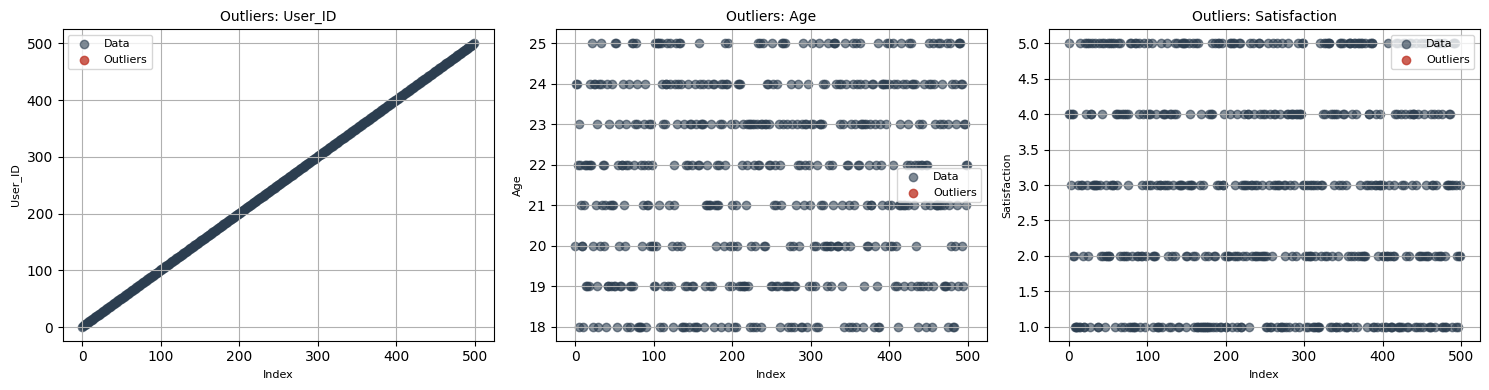

In [10]:
def plot_outliers_iqr(data):
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    threshold = 1.5
    n_cols = 3 
    n_rows = -(-len(numeric_columns) // n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4), squeeze=False)
    axes = axes.flatten() 
    
    color_data = colors[0]
    color_outliers = colors[-1]
    
    for idx, column in enumerate(numeric_columns):
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        outliers = (data[column] < lower_bound) | (data[column] > upper_bound)

        axes[idx].scatter(data.index, data[column], label='Data', alpha=0.6, color=color_data)
        axes[idx].scatter(data.index[outliers], data[column][outliers], label='Outliers', color=color_outliers, alpha=0.8)
        axes[idx].set_title(f"Outliers: {column}", fontsize=10)
        axes[idx].set_xlabel("Index", fontsize=8)
        axes[idx].set_ylabel(column, fontsize=8)
        axes[idx].legend(fontsize=8)
        axes[idx].grid(True)
        
    for ax in axes[len(numeric_columns):]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
plot_outliers_iqr(df)

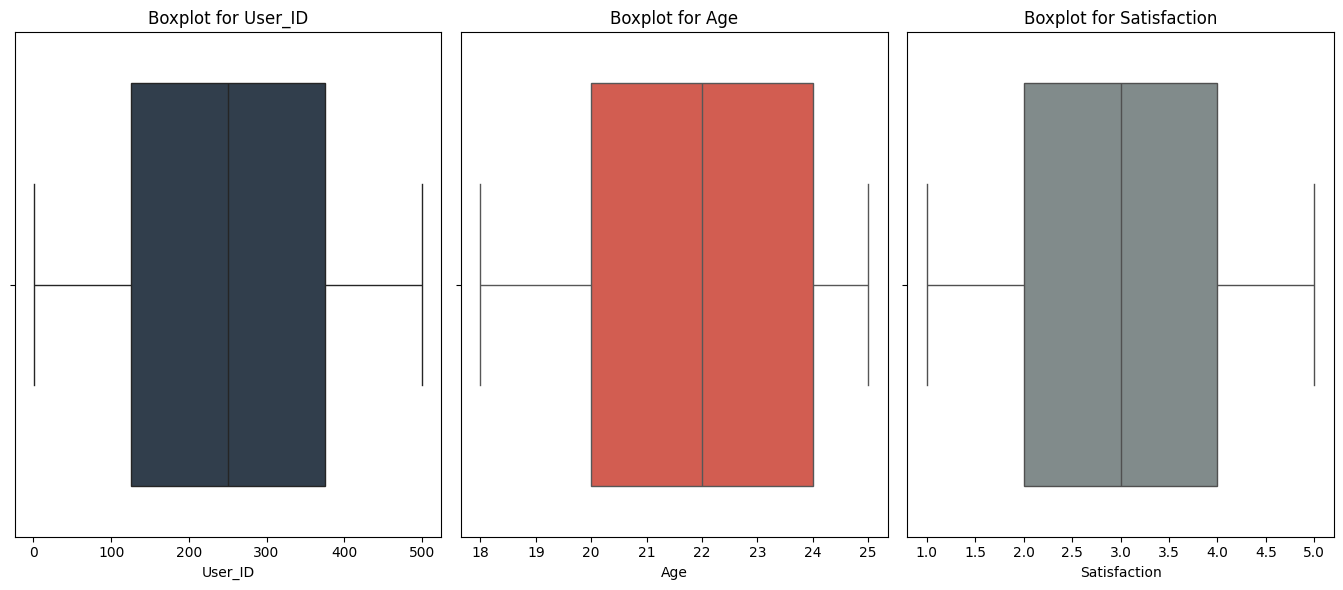

In [11]:
def plot_outliers(df):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    num_columns = len(numeric_columns)
    num_per_row = 4 
    num_rows = -(-num_columns // num_per_row) 

    fig, axes = plt.subplots(num_rows, num_per_row, figsize=(18, 6 * num_rows))
    axes = axes.flatten()
    
    for i, column in enumerate(numeric_columns):
        sns.boxplot(x=df[column], ax=axes[i], color=ordered_colors[i % len(ordered_colors)])
        axes[i].set_title(f'Boxplot for {column}')
    
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

plot_outliers(df)

In [12]:
def remove_outliers(df):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    
    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df

df = remove_outliers(df)

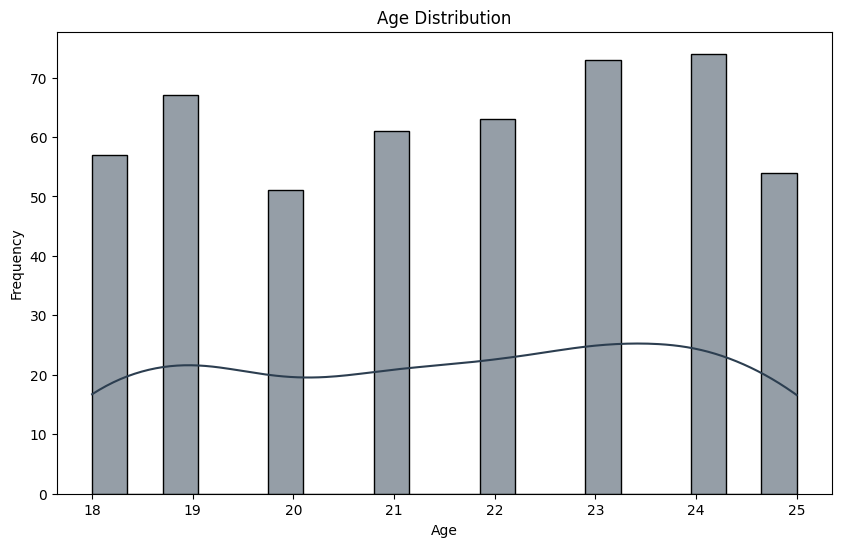

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

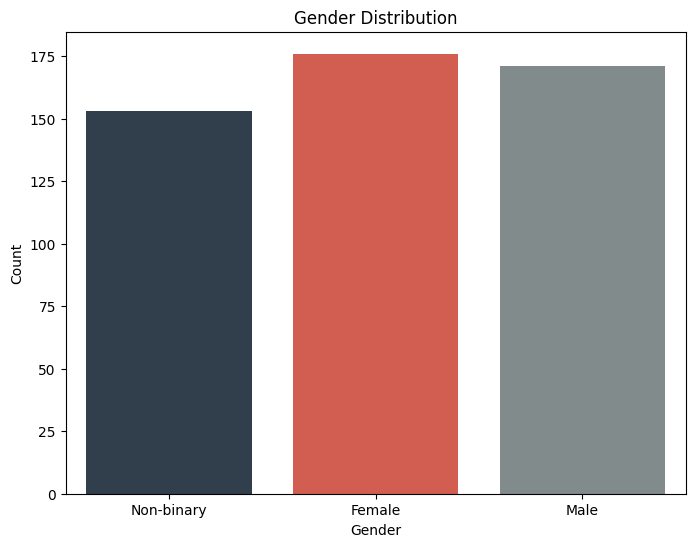

In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', data=df, palette=ordered_colors)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

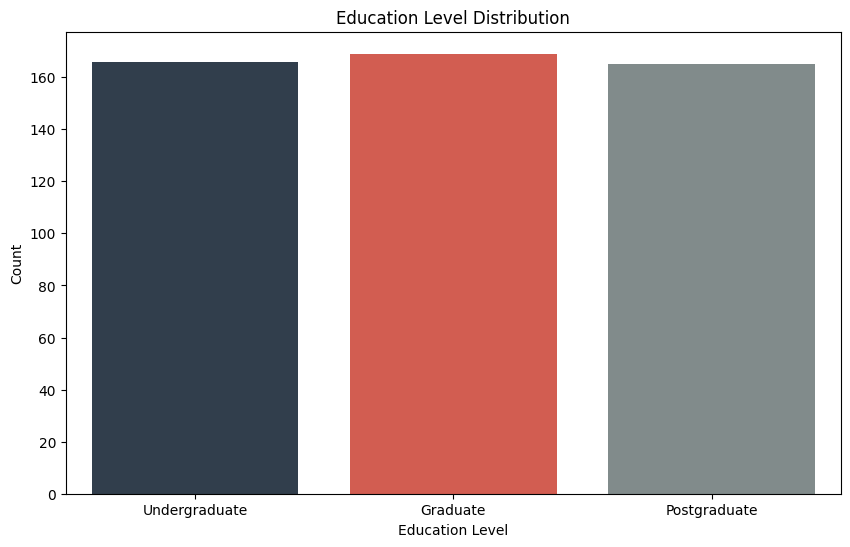

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Education', data=df, palette=ordered_colors)
plt.title('Education Level Distribution')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.show()

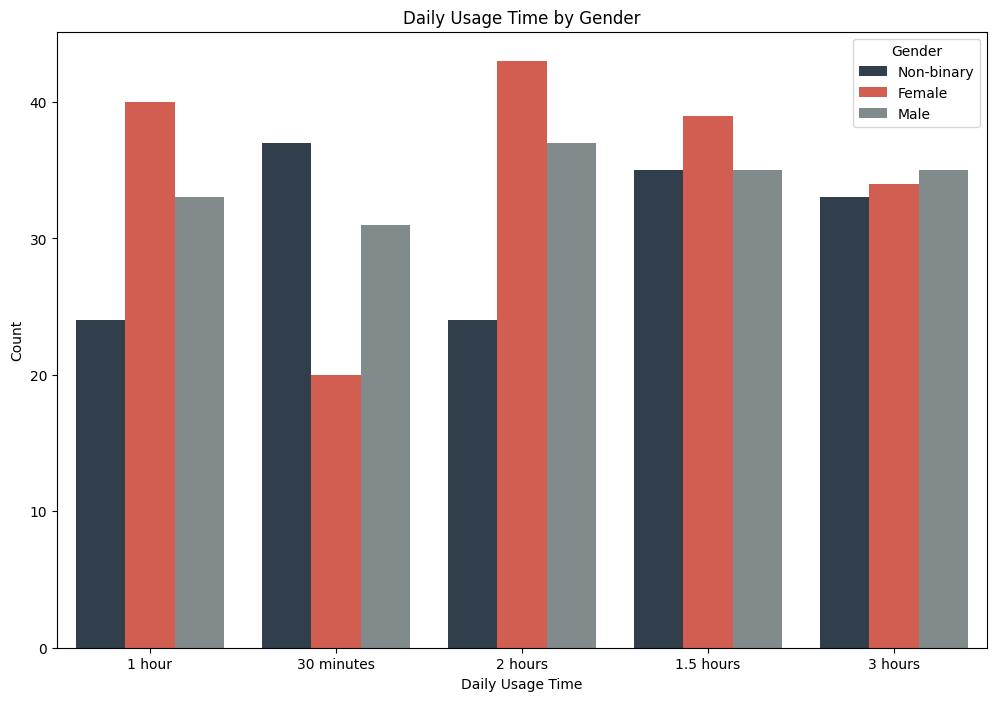

In [16]:
plt.figure(figsize=(12, 8))
sns.countplot(x='Daily_Usage_Time', hue='Gender', data=df, palette=ordered_colors)
plt.title('Daily Usage Time by Gender')
plt.xlabel('Daily Usage Time')
plt.ylabel('Count')
plt.show()

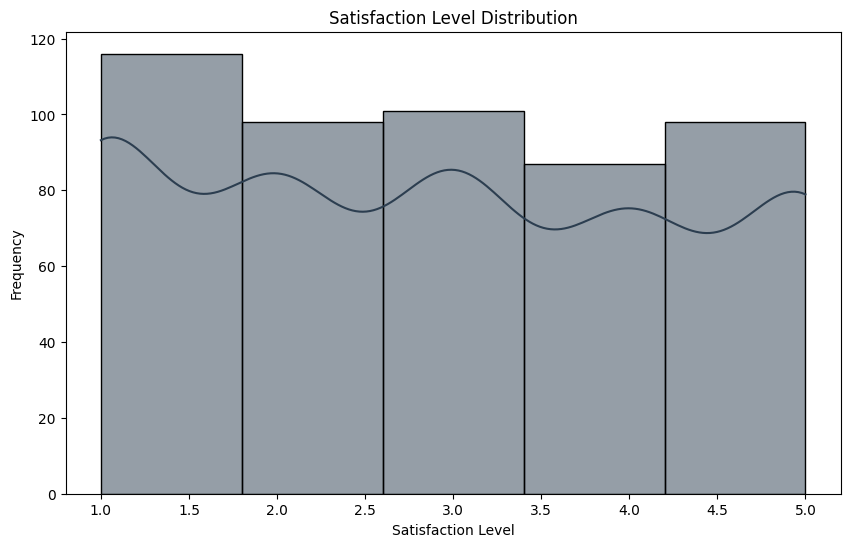

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Satisfaction'], bins=5, kde=True, palette=ordered_colors[1])
plt.title('Satisfaction Level Distribution')
plt.xlabel('Satisfaction Level')
plt.ylabel('Frequency')
plt.show()

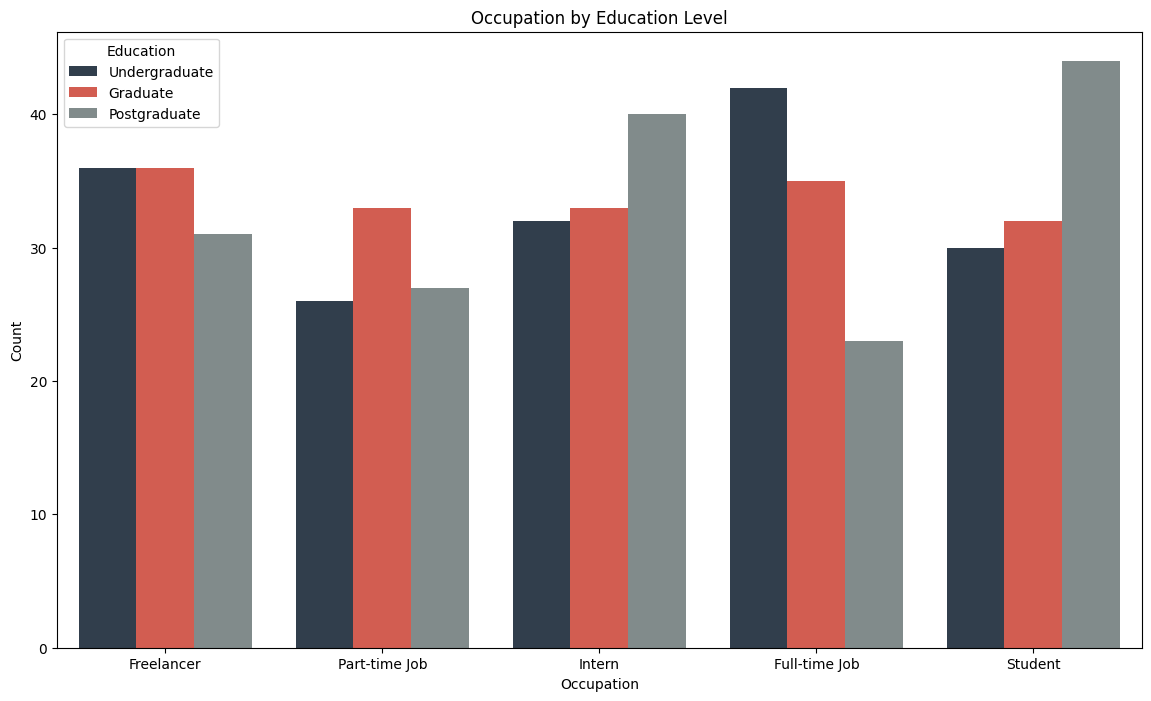

In [18]:
plt.figure(figsize=(14, 8))
sns.countplot(x='Occupation', hue='Education', data=df, palette=ordered_colors)
plt.title('Occupation by Education Level')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.show()

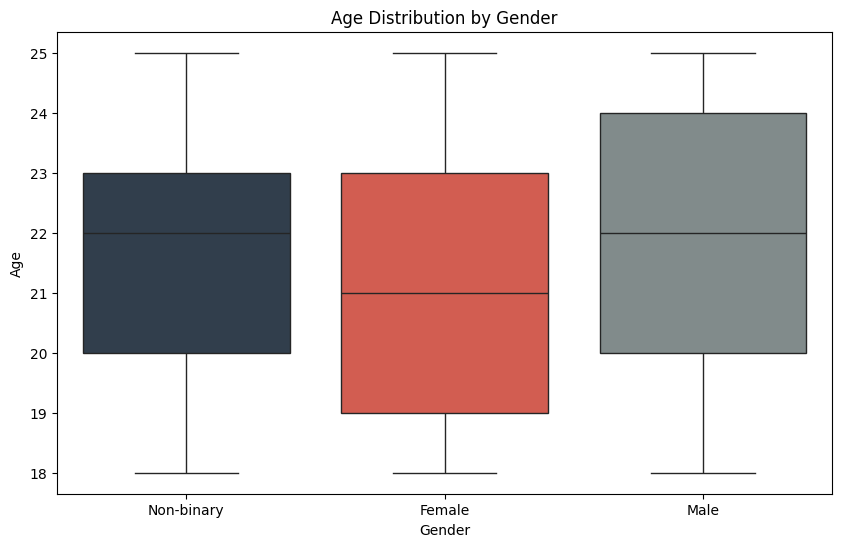

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Age', data=df, palette=ordered_colors)
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()

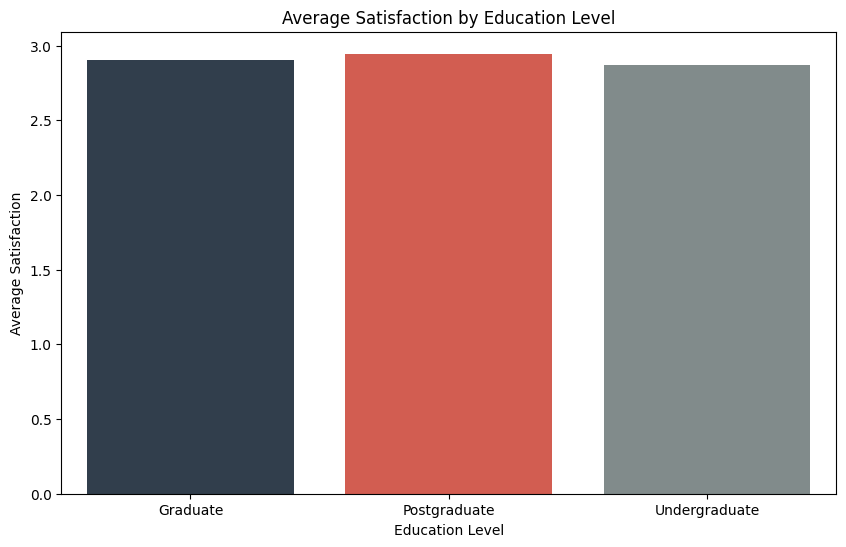

In [20]:
plt.figure(figsize=(10, 6))
avg_satisfaction = df.groupby('Education')['Satisfaction'].mean().reset_index()
sns.barplot(x='Education', y='Satisfaction', data=avg_satisfaction, palette=ordered_colors)
plt.title('Average Satisfaction by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Average Satisfaction')
plt.show()

In [21]:
df = df.drop(columns=['User_ID'])

In [22]:
encoder = LabelEncoder()

label_mappings = {}

for col in df.select_dtypes('object'):
    df[col] = encoder.fit_transform(df[col])
    label_mappings[col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

for col, mapping in label_mappings.items():
    print(f"Column: {col}")
    for label, code in mapping.items():
        print(f"{code} -> {label}")
    print()

Column: Gender
0 -> Female
1 -> Male
2 -> Non-binary

Column: Location
0 -> Bangalore
1 -> Chennai
2 -> Delhi
3 -> Hyderabad
4 -> Kolkata
5 -> Mumbai
6 -> Pune

Column: Education
0 -> Graduate
1 -> Postgraduate
2 -> Undergraduate

Column: Occupation
0 -> Freelancer
1 -> Full-time Job
2 -> Intern
3 -> Part-time Job
4 -> Student

Column: Primary_App
0 -> Bumble
1 -> Hinge
2 -> OkCupid
3 -> Tinder

Column: Secondary_Apps
0 -> Bumble
1 -> Hinge
2 -> OkCupid
3 -> Tinder

Column: Usage_Frequency
0 -> Daily
1 -> Monthly
2 -> Weekly

Column: Daily_Usage_Time
0 -> 1 hour
1 -> 1.5 hours
2 -> 2 hours
3 -> 3 hours
4 -> 30 minutes

Column: Reason_for_Using
0 -> Casual Dating
1 -> Casual Fun
2 -> Finding a Partner
3 -> Social Interaction

Column: Challenges
0 -> Lack of Genuine Matches
1 -> Safety Concerns
2 -> Time-Wasting

Column: Desired_Features
0 -> AI Recommendations
1 -> Audio Calls
2 -> Detailed Profiles
3 -> Location-Based Matching
4 -> Video Calls

Column: Preferred_Communication
0 -> Text

In [23]:
from sklearn.model_selection import train_test_split

X = df.drop('Age',axis = 1)
y = df['Age']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)

(400, 14) (100, 14)


In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
knn = KNeighborsRegressor()
knn_model = knn.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [27]:
knn_mse = mean_squared_error(y_test, y_pred)
knn_r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {knn_mse}")
print(f"R2 Score: {knn_r2}")

Mean Squared Error: 6.2943999999999996
R2 Score: -0.17092045539102618


In [28]:
knn = KNeighborsRegressor()

knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11], 
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn_cv_model = GridSearchCV(estimator=knn, param_grid=knn_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
knn_cv_model.fit(X_train, y_train)

print("Best parameters:", knn_cv_model.best_params_)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}


In [29]:
knn = KNeighborsRegressor(n_neighbors=11, weights='distance', metric='manhattan')

knn_tuned = knn.fit(X_train, y_train)
y_pred = knn_tuned.predict(X_test)

knn_tuned_mse = mean_squared_error(y_test, y_pred)
knn_tuned_r2 = r2_score(y_test, y_pred)

print("Model MSE:", knn_tuned_mse)
print("Model R² Score:", knn_tuned_r2)

Model MSE: 5.526018762252415
Model R² Score: -0.027981762454872827


In [30]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [31]:
lr_mse = mean_squared_error(y_test, y_pred)
lr_r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {lr_mse}")
print(f"R2 Score: {lr_r2}")

Mean Squared Error: 5.396914006015484
R2 Score: -0.00396495386849538


In [32]:
lr = LinearRegression()

lr_params = {
    'fit_intercept': [True, False],  
    'copy_X': [True, False],
    'positive': [True, False]
}

lr_cv_model = GridSearchCV(estimator=lr, param_grid=lr_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lr_cv_model.fit(X_train, y_train)

print("Best parameters:", lr_cv_model.best_params_)

Best parameters: {'copy_X': True, 'fit_intercept': True, 'positive': True}


In [33]:
lr = LinearRegression(fit_intercept=True, copy_X=True, positive=False)
lr_tuned = lr.fit(X_train, y_train)
y_pred = lr_tuned.predict(X_test)

lr_tuned_mse = mean_squared_error(y_test, y_pred)
lr_tuned_r2 = r2_score(y_test, y_pred)

print("Model MSE:", lr_tuned_mse)
print("Model R² Score:", lr_tuned_r2)

Model MSE: 5.396914006015484
Model R² Score: -0.00396495386849538


In [34]:
rf = RandomForestRegressor(random_state = 42)
rf_model = rf.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [35]:
rf_mse = mean_squared_error(y_test, y_pred)
rf_r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {rf_mse}")
print(f"R2 Score: {rf_r2}")

Mean Squared Error: 5.322958000000001
R2 Score: 0.009792767318996698


In [36]:
rf = RandomForestRegressor()

rf_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4], 
    'bootstrap': [True, False]
}

rf_cv_model = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_cv_model.fit(X_train, y_train)

print("Best parameters:", rf_cv_model.best_params_)

Best parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}


In [37]:
rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=2, min_samples_leaf=1, bootstrap=True)
rf_tuned = rf.fit(X_train, y_train)
y_pred = rf_tuned.predict(X_test)

rf_tuned_mse = mean_squared_error(y_test, y_pred)
rf_tuned_r2 = r2_score(y_test, y_pred)

print("Model MSE:", rf_tuned_mse)
print("Model R² Score:", rf_tuned_r2)

Model MSE: 5.225579853558083
Model R² Score: 0.0279076096513724


In [38]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train),
y_pred = dt_model.predict(X_test)

In [39]:
dt_mse = mean_squared_error(y_test, y_pred)
dt_r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {dt_mse}")
print(f"R2 Score: {dt_r2}")

Mean Squared Error: 9.66
R2 Score: -0.7970087060049114


In [40]:
dt = DecisionTreeRegressor()

dt_params = {
    'max_depth': [3, 5, 7, 10, None], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_cv_model = GridSearchCV(estimator=dt, param_grid=dt_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
dt_cv_model.fit(X_train, y_train)

print("Best parameters:", dt_cv_model.best_params_)

Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [41]:
dt = DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=4)
dt_tuned = dt.fit(X_train, y_train)
y_pred = dt_tuned.predict(X_test)

dt_tuned_mse = mean_squared_error(y_test, y_pred)
dt_tuned_r2 = r2_score(y_test, y_pred)

print("Model MSE:", dt_tuned_mse)
print("Model R² Score:", dt_tuned_r2)

Model MSE: 6.004019467185065
Model R² Score: -0.11690220016092456


In [42]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train),
y_pred = xgb_model.predict(X_test)

In [43]:
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {xgb_mse}")
print(f"R2 Score: {xgb_r2}")

Mean Squared Error: 6.103124908539648
R2 Score: -0.1353386640548706


In [44]:
xgb = XGBRegressor()

xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0]
}

xgb_cv_model = GridSearchCV(estimator=xgb, param_grid=xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_cv_model.fit(X_train, y_train)

print("Best parameters:", xgb_cv_model.best_params_)

Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


In [45]:
xgb = XGBRegressor(n_estimators=300, learning_rate=0.2, max_depth=3, min_child_weight=5, subsample=1.0)
xgb_tuned = xgb.fit(X_train, y_train)
y_pred = xgb_tuned.predict(X_test)

xgb_tuned_mse = mean_squared_error(y_test, y_pred)
xgb_tuned_r2 = r2_score(y_test, y_pred)

print("Model MSE:", xgb_tuned_mse)
print("Model R² Score:", xgb_tuned_r2)

Model MSE: 6.707090056853267
Model R² Score: -0.24769163131713867


In [46]:
models = ['KNN', 'XGBoost', 'Random Forest', 'Linear Regression', 'Decision Tree']

mse_scores = [
    knn_tuned_mse,  
    xgb_tuned_mse,  
    rf_tuned_mse,   
    lr_tuned_mse,   
    dt_tuned_mse    
]

r2_scores = [
    knn_tuned_r2,   
    xgb_tuned_r2,   
    rf_tuned_r2,    
    lr_tuned_r2,    
    dt_tuned_r2     
]

mse_values = [f'{score:.4f}' for score in mse_scores]  
r2_values = [f'{score:.4f}' for score in r2_scores]    

results_df = pd.DataFrame({
    'Model': models,
    'MSE': mse_values,
    'R^2': r2_values
})

print(results_df)

               Model     MSE      R^2
0                KNN  5.5260  -0.0280
1            XGBoost  6.7071  -0.2477
2      Random Forest  5.2256   0.0279
3  Linear Regression  5.3969  -0.0040
4      Decision Tree  6.0040  -0.1169
